<h1 style="font-size: 48px;">Harmonic balance method </h1>
In this juypyter notebook we are testing Harmonic Balance method for a simple advection problem. 
There is no diffusion. The velocity is constant. Sine wave is generated in the left boundary. It travels and passes throught the right boundary.  Harmonic balance method is implemented similar to this publication.

https://www.researchgate.net/profile/Gregor-Cvijetic/publication/309328469_Finite_Volume_Implementation_of_the_Harmonic_Balance_Method_for_Periodic_Non-Linear_Flows/links/59d498594585150177fc5a1b/Finite-Volume-Implementation-of-the-Harmonic-Balance-Method-for-Periodic-Non-Linear-Flows.pdf

In [14]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import time as tm
import logging

# creating matrix called $P_i$ 

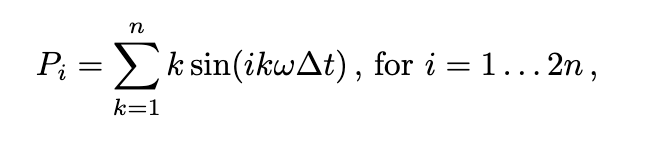
Equation (17) from the publication

In [19]:
def P_i(i,f,n):
    w = 2 * np.pi * f
    T = 1 / f
    k = np.arange(n) + 1
    dt = T / (2 * n + 1) # given in the paper Equation (18)
    return np.sum(k * np.sin(i * k * w * dt))

# creating $E^{-1}AE$ matrix

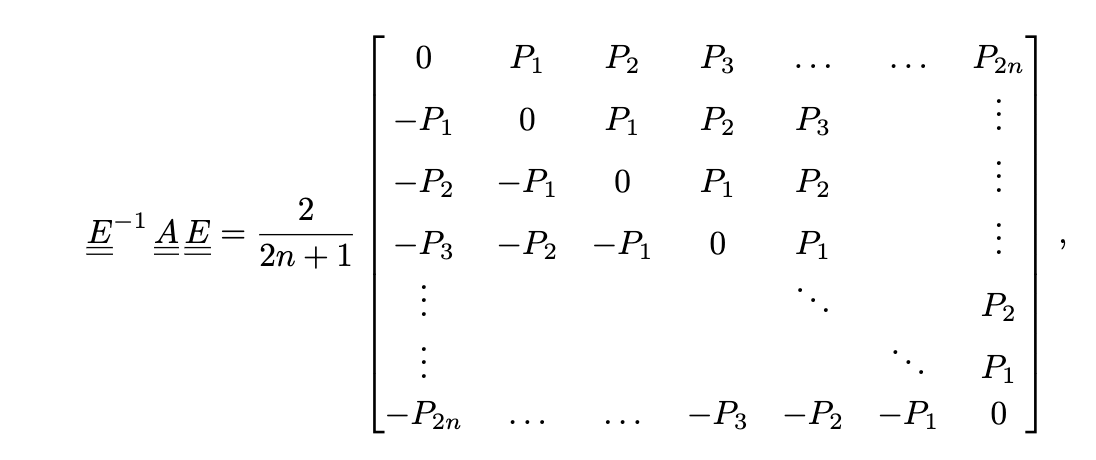
Equation (16) from the publication

In [16]:
def EAE(f,n):
    retMatrix = np.ones((2 * n + 1, 2 * n + 1), dtype = float)
    for a in np.arange(2 * n + 1):
        for b in np.arange(2 * n + 1):
            retMatrix[a,b] = np.sign(b-a) * P_i(abs(b-a),f,n)
    return (2 / (2 * n + 1)) * retMatrix

# Harmonic Balance operator LHS without the divergence term

In [43]:
def harmonicOperatorMatrix(nn):
    n = (2 * nn + 1) ** 2
    mat2 = np.zeros((n,n),float)
    
    eae = (EAE(1,nn))
    print("this is EAE")
    print(eae)
    print()
    
    for a in np.arange(2*nn+1):
        print("\n\n\n")
        print("diagonal #", str(a) , "of EAE")
        print(np.diag(eae,a))
        print("diagonal #", str(-a), "of EAE")
        print(np.diag(eae,-a))
        print("The size of this diagonal should be", ((np.diag(eae,-a).size))*(2*nn+1))
        diagg_up = np.zeros(((np.diag(eae,-a).size))*(2*nn+1))
        diagg_down = np.zeros(((np.diag(eae,-a).size))*(2*nn+1))
        for rc in np.arange(np.diag(eae,-a).size):
            curdiag_up = np.diag(eae,a)
            curdiag_down = np.diag(eae,-a)
            diagg_up[1+2*rc+rc*(2*nn + 1 - 2):1+2*rc+(rc+1)*(2*nn + 1 - 2)] = curdiag_up[rc]
            diagg_down[1+2*rc+rc*(2*nn + 1 - 2):1+2*rc+(rc+1)*(2*nn + 1 - 2)] = curdiag_down[rc]
        np.fill_diagonal(mat2[:,abs(a*(2*nn+1)):], diagg_up)
        np.fill_diagonal(mat2[abs(a*(2*nn+1)):, :], diagg_down)
        print("the upper diagonal elements in position #", a ,"are")
        print(diagg_up)
        print("the lower diagonal elements in position #", a ,"are")
        print(diagg_down)
    
    print("\n\n\nthis is the Operator matrix that we created")
    mm2= np.round(mat2, decimals=2)
    print(mm2)
    np.savetxt('my_array2.txt', mm2, fmt='%.2f')

    return mat2

# Printing HB operator

In [22]:
n=2
operator = harmonicOperatorMatrix(n)

this is EAE
[[ 0.          0.85065081 -0.52573111  0.52573111 -0.85065081]
 [-0.85065081  0.          0.85065081 -0.52573111  0.52573111]
 [ 0.52573111 -0.85065081  0.          0.85065081 -0.52573111]
 [-0.52573111  0.52573111 -0.85065081  0.          0.85065081]
 [ 0.85065081 -0.52573111  0.52573111 -0.85065081  0.        ]]





diagonal # 0 of EAE
[0. 0. 0. 0. 0.]
diagonal # 0 of EAE
[0. 0. 0. 0. 0.]
The size of this diagonal should be 25
the upper diagonal elements in position # 0 are
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
the lower diagonal elements in position # 0 are
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]




diagonal # 1 of EAE
[0.85065081 0.85065081 0.85065081 0.85065081]
diagonal # -1 of EAE
[-0.85065081 -0.85065081 -0.85065081 -0.85065081]
The size of this diagonal should be 20
the upper diagonal elements in position # 1 are
[0.         0.85065081 0.85065081 0.85065081 0.         0.
 0.85065081 0.8

# Divergence operator Matrix

In [44]:
def divergenceOperator(nn):
    n = (2 * nn + 1) ** 2
    mat2 = np.zeros((n,n),float)
    diagg_up = np.zeros(n - 1)
    diagg_down = np.zeros(n - 1)
    for a in np.arange(2 * nn + 1):
        for b in np.arange(2 * nn + 1):
            strt = 2 * a + a * (2 * nn + 1 - 2)
            endd = 2 * a + (a + 1) * (2 * nn + 1 - 2)
            #print(strt,endd)
            diagg_down[strt:endd] = 1
            #diagg_down[1+2*rc+rc*(2*nn + 1 - 2):1+2*rc+(rc+1)*(2*nn + 1 - 2)] = curdiag_down[rc]
        #np.fill_diagonal(mat2[:,abs(a*(2*nn+1)):], diagg_up)
        #np.fill_diagonal(mat2[abs(a*(2*nn+1)):, :], diagg_down)
    diagg_up[1:] = - diagg_down[:-1]
    print("lower diagonal")
    print(diagg_down)   
    print("lower diagonal")
    print(diagg_up)  
    np.fill_diagonal(mat2[:,1:], diagg_up)
    np.fill_diagonal(mat2[1:, :], diagg_down)
    
    print("\n\n\nthis is the Operator matrix that we created")
    mm2= np.round(mat2, decimals=2)
    print(mm2)
    np.savetxt('divOperator.txt', mm2, fmt='%.2f')
    return mat2

In [46]:
divergenceOperator(2)

lower diagonal
[1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.]
lower diagonal
[ 0. -1. -1. -1. -0. -0. -1. -1. -1. -0. -0. -1. -1. -1. -0. -0. -1. -1.
 -1. -0. -0. -1. -1. -1.]



this is the Operator matrix that we created
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
      

# BC operator Matrix

In [57]:
def BCOperatorMatrix(nn):
    n = (2 * nn + 1) ** 2
    mat2 = np.zeros((n,n),float)
    diagg = np.ones(n)
    for a in np.arange(2 * nn + 1):
        for b in np.arange(2 * nn + 1):
            strt = 1 + 2 * a + a * (2 * nn + 1 - 2)
            endd = 1 + 2 * a + (a + 1) * (2 * nn + 1 - 2)
            #print(strt,endd)
            diagg[strt:endd] = 0
            #diagg_down[1+2*rc+rc*(2*nn + 1 - 2):1+2*rc+(rc+1)*(2*nn + 1 - 2)] = curdiag_down[rc]
        #np.fill_diagonal(mat2[:,abs(a*(2*nn+1)):], diagg_up)
        #np.fill_diagonal(mat2[abs(a*(2*nn+1)):, :], diagg_down)
    print("diagonal")
    print(diagg)  
    np.fill_diagonal(mat2[:,0:], diagg)
    
    print("\n\n\nthis is the Operator matrix that we created")
    mm2= np.round(mat2, decimals=2)
    print(mm2)
    np.savetxt('divOperator.txt', mm2, fmt='%.2f')
    return mat2

In [58]:
BCOperatorMatrix(2)

diagonal
[1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1.]



this is the Operator matrix that we created
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

# Sine wave test case 

## fluid model

In [142]:
#ADVECTION SOLVING MATRIX (1D FINITE VOLUME METHOD) ==========================================================
def AdvectionAlgorithm(dx,dt,velocity,density):
    #this is a simple yet very efficient code that solves the advection of the particles using FVM
    flux = (0.5*(velocity[1:]*density[1:]+velocity[:-1]*density[:-1])-
            0.5*0.5*abs(velocity[1:]+velocity[:-1])*(density[1:]-density[:-1]))*dt
    density[1:-1] += -(flux[1:]-flux[:-1])/dx
    return density[1:-1]

In [146]:
distance = 1 # meters
frequency = 5 # hertz
velocity = 1 #m/s
grid = 100 # 50cells total
timesteps = 5000
amplitude = 1 # 1 meters

In [147]:
#matrices
densityM = 0.000001*np.ones(grid)
print(wave)
xvalueM = np.arange(grid)/grid
print(xvalue)
velocityM = velocity * np.ones(grid)
dx = xvalueM[1]-xvalueM[0]
dt = 0.01

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98]


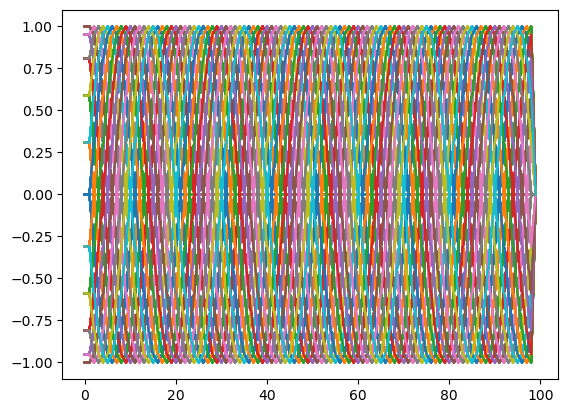

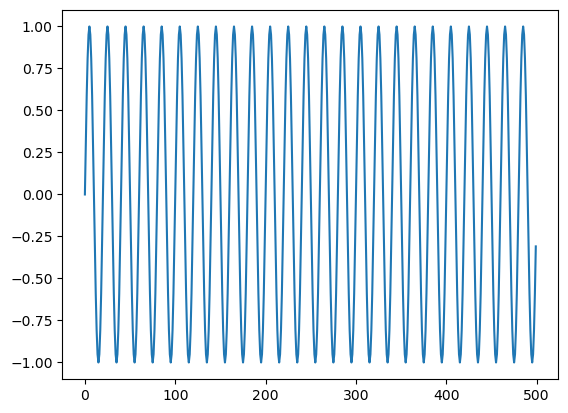

In [148]:
bcval = np.zeros(500)
for t in np.arange(500):
    time = t * dt
    densityM[0] = amplitude * np.sin(2 * np.pi*frequency * time)
    #print(densityM[0])
    bcval[t] = densityM[0]
    densityM[1:-1] = (AdvectionAlgorithm(dx,dt,velocityM,densityM))
    plt.plot(densityM)

plt.show()

plt.plot(bcval)
plt.show()